In [4]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm

from src.bayesian import grid_serach_var

az.style.use("arviz-darkgrid")
from config import seed
rng = np.random.default_rng(seed=seed)

print(pm.__version__)

5.0.1


In [6]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}


from config import plt_config
plt.rcParams.update(plt_config)

## BVAR

In [4]:
from src.process_data import load_data
from config import fred_dict
df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'is_test', 'w', 'S'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

df = df.drop(['L'], axis=1).iloc[-120:].copy()
print(tuple(df.columns))

forecast_len = 10

data = df[:-forecast_len].copy()
test_data = df[-forecast_len:].copy()
data.shape, test_data.shape


Error occured 'S', file_dict may be incomplete
Error occured 'is_test', file_dict may be incomplete
('Y', 'pi', 'r', 'I', 'C')


((110, 5), (10, 5))

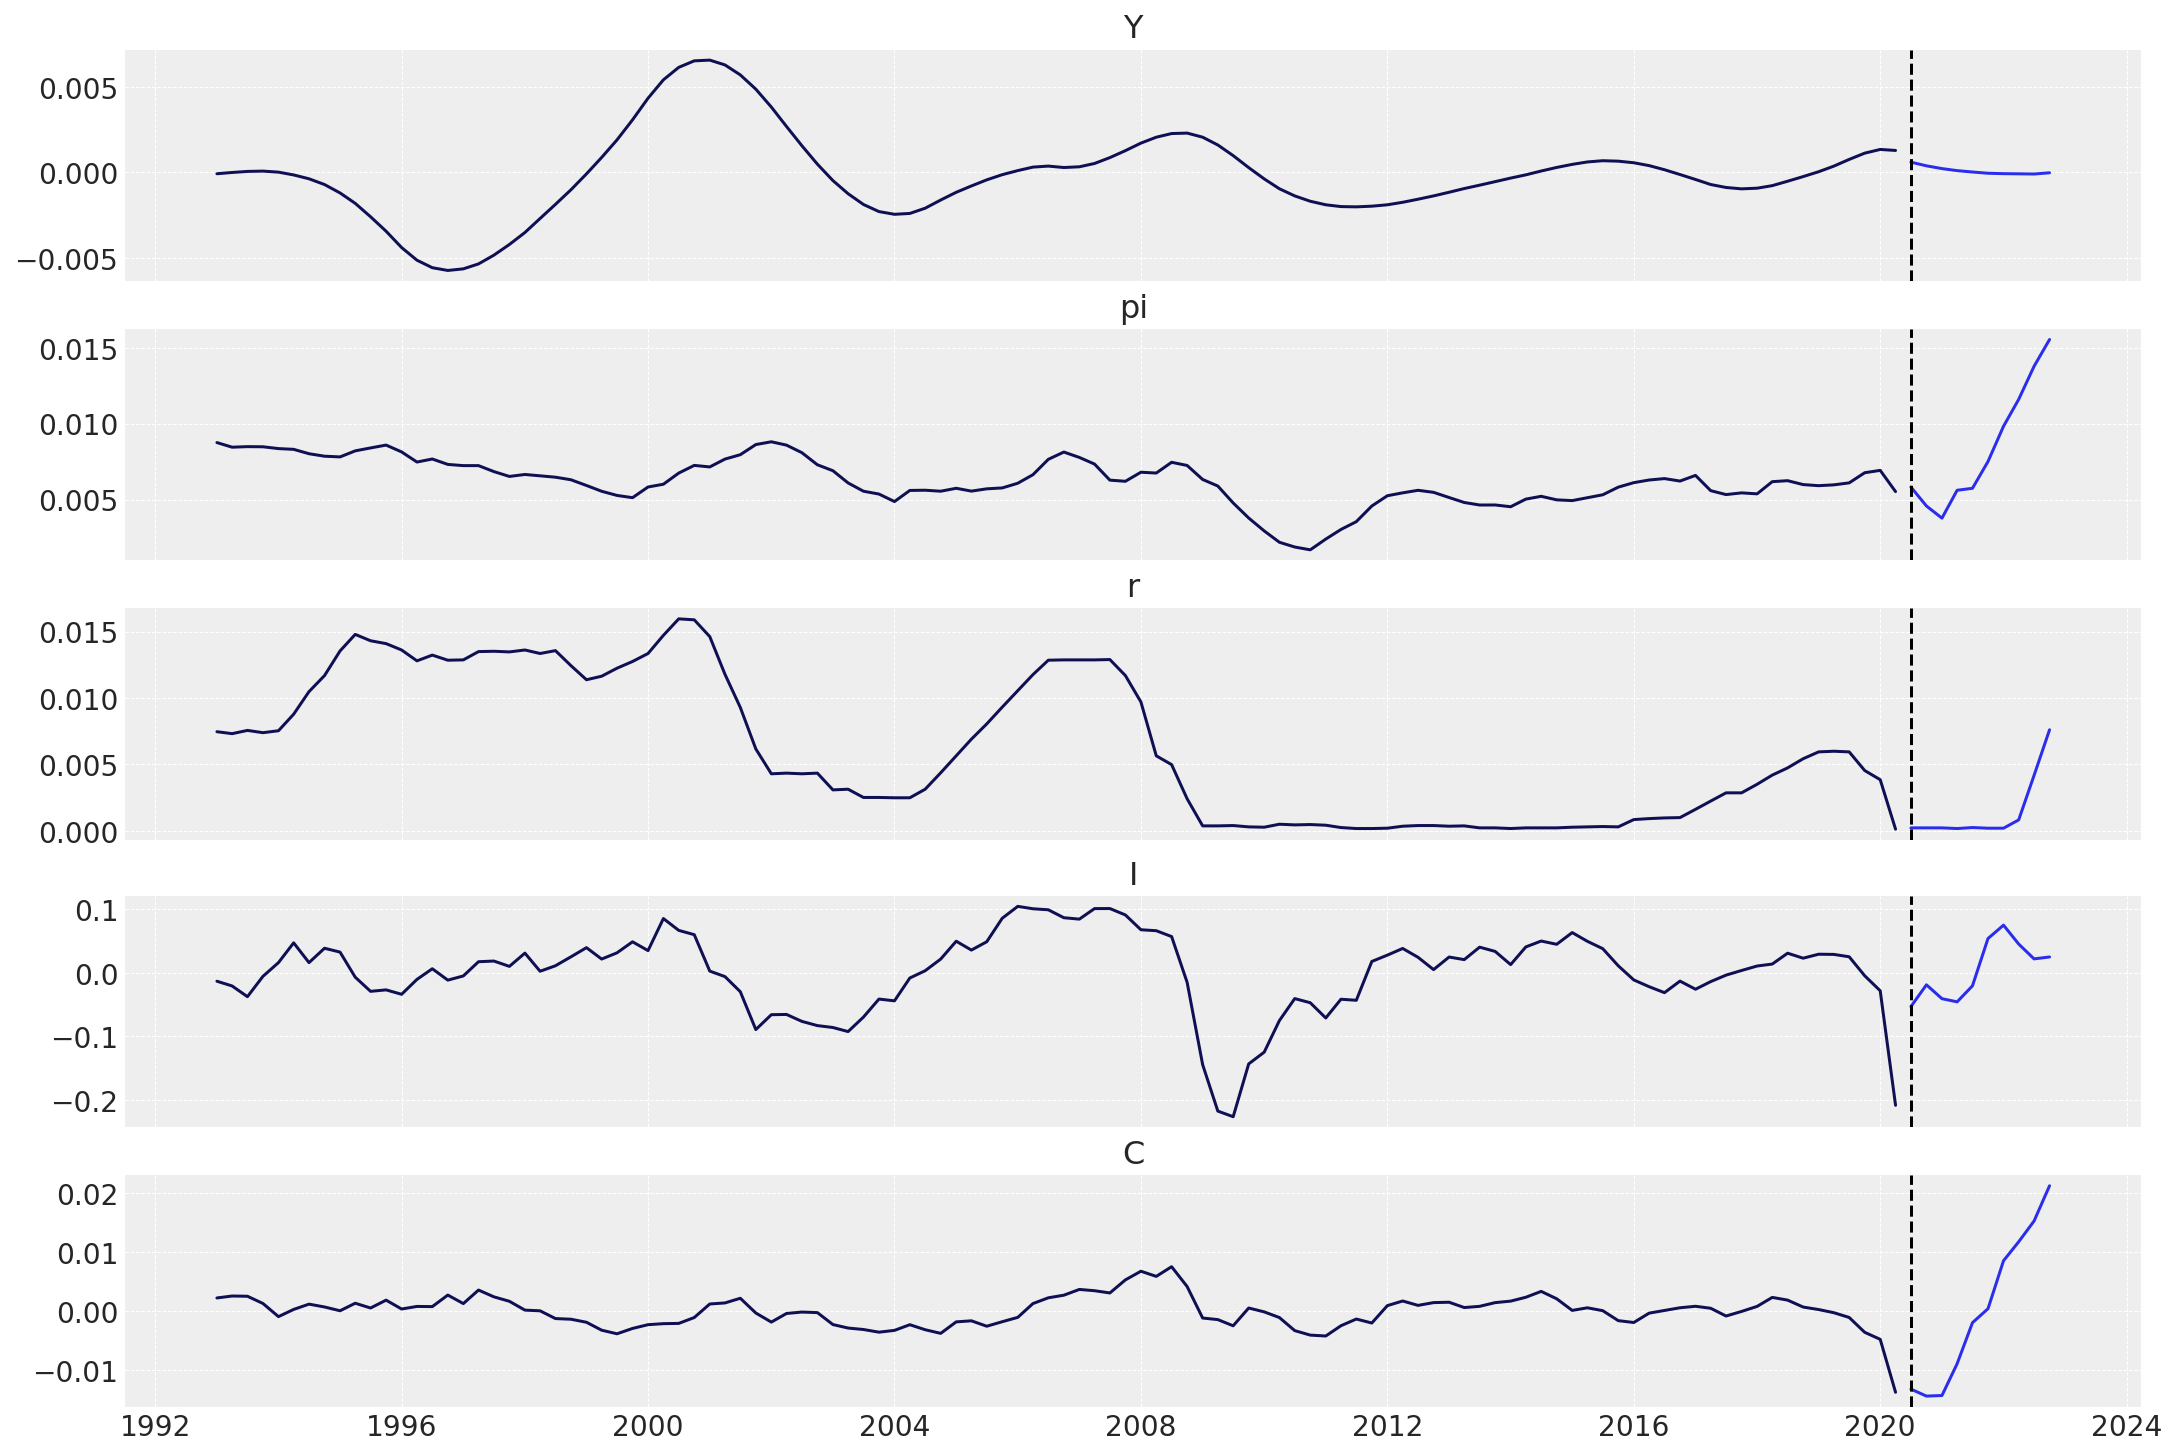

In [5]:
_, ax = plt.subplots(data.shape[1], 1, figsize=(15, 2 * df.shape[1]), sharex=True)

for i in range(0, data.shape[1]):
    ax[i].plot(data.iloc[:, i], color=dark["C0"], label="train")
    ax[i].plot(test_data.iloc[:, i], color="C0", label="test")
    ax[i].set_title(data.columns[i])
    
    ax[i].axvline(df.index[-forecast_len], ls='--', color='k')


In [6]:
# get p from statsmodels BIC

In [7]:
from statsmodels.tsa.api import VAR
mod = VAR(data)
res = mod.fit(maxlags=15, ic='aic')

Lowest AIC at [3] lags


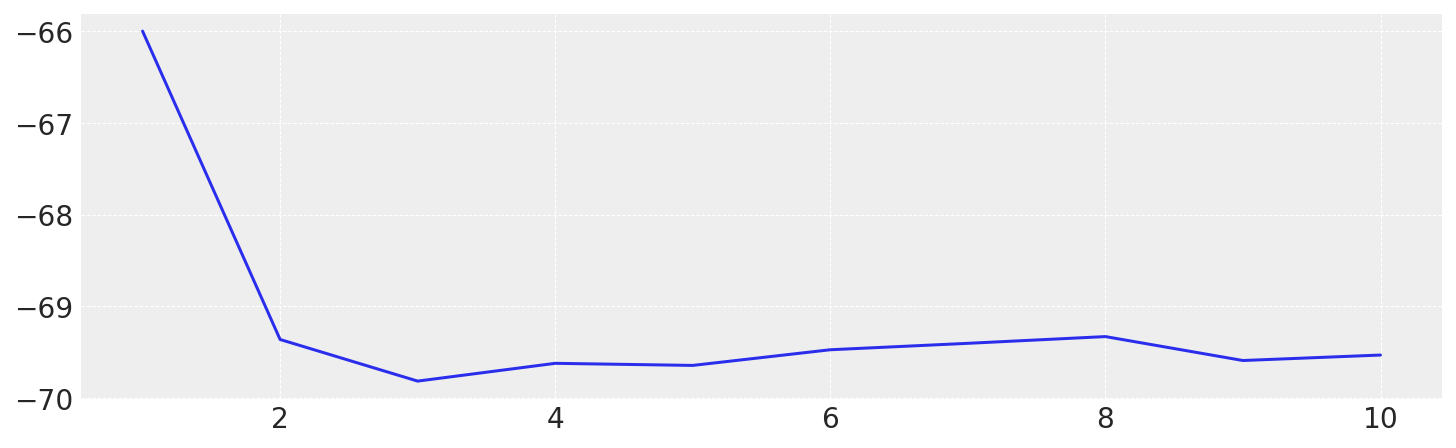

In [8]:
p_max = 10
ics = np.array(grid_serach_var(data, p_max=p_max))

print(f'Lowest AIC at {np.where(1==(ics / np.min(ics)))[0] + 1} lags')
plt.plot(range(1, p_max+1), ics);

In [9]:
# get BVAR

In [10]:
lags = 3

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": tuple(df.columns),
    "cross_vars": tuple(df.columns),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_list = []
    for ind in range(0, len(coords['cross_vars'])):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[i, ind] * data.values[lags-(i+1): -(i+1)], axis=-1) for i in range(lags)
            ]
            , axis=0
        )        
        ar_list.append(ar)
        
    mean = intercept + pm.math.stack(ar_list, axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

In [11]:
with BVAR_model:
    trace = pm.sample(chains=4, draws=1_000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 398 seconds.


In [12]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

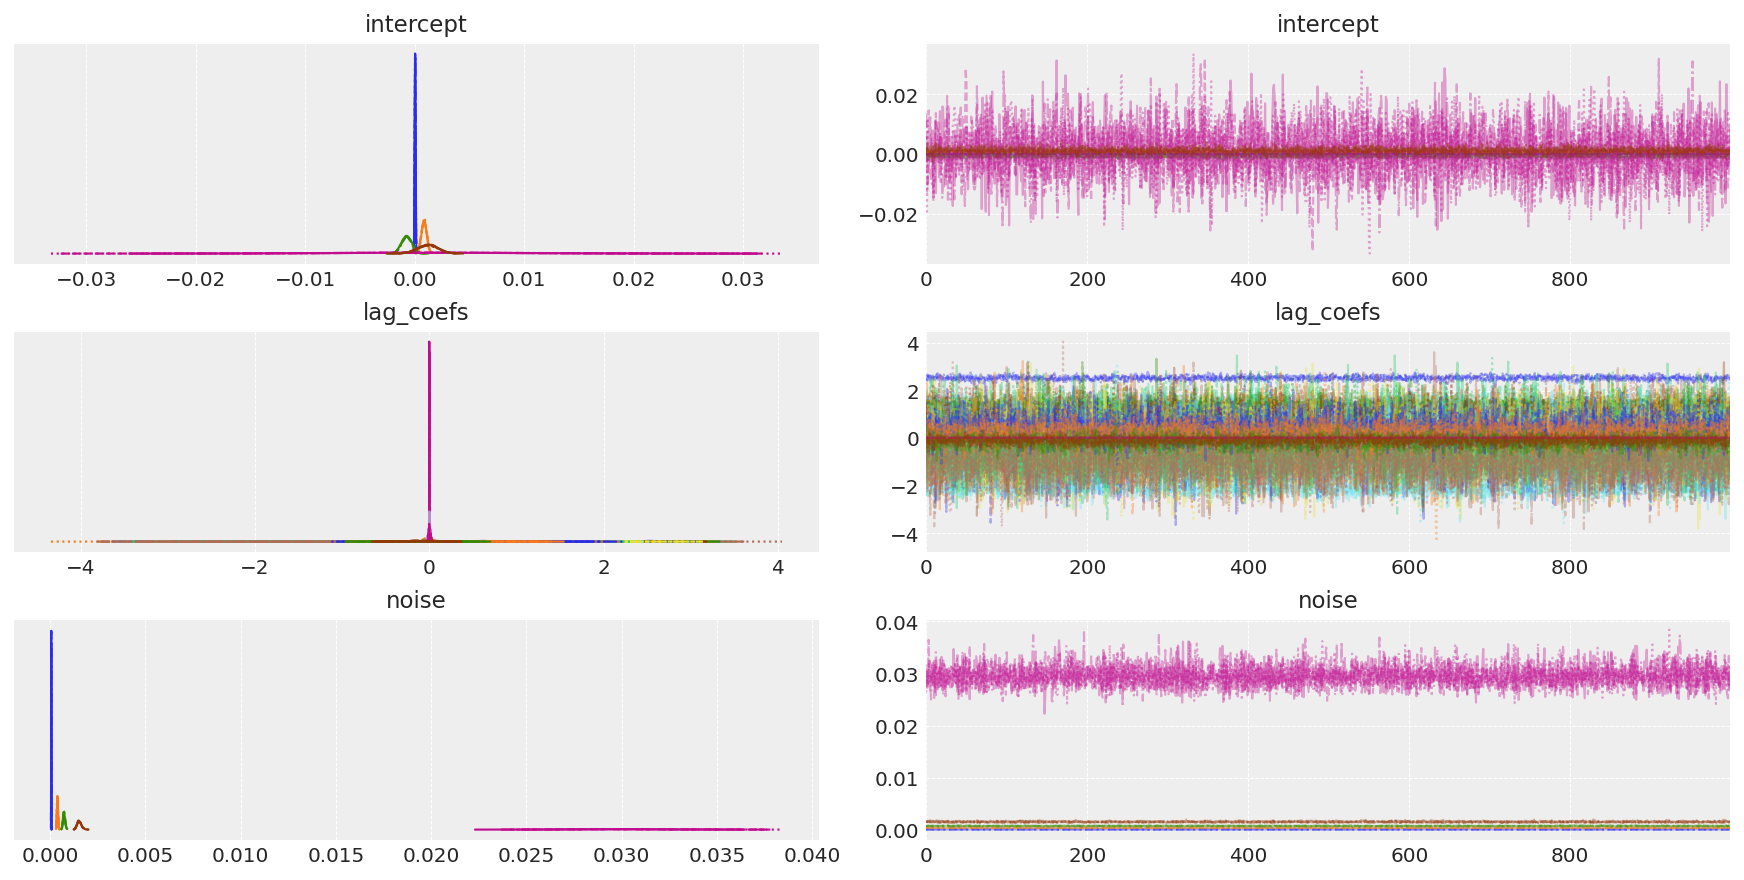

In [12]:
az.plot_trace(trace);

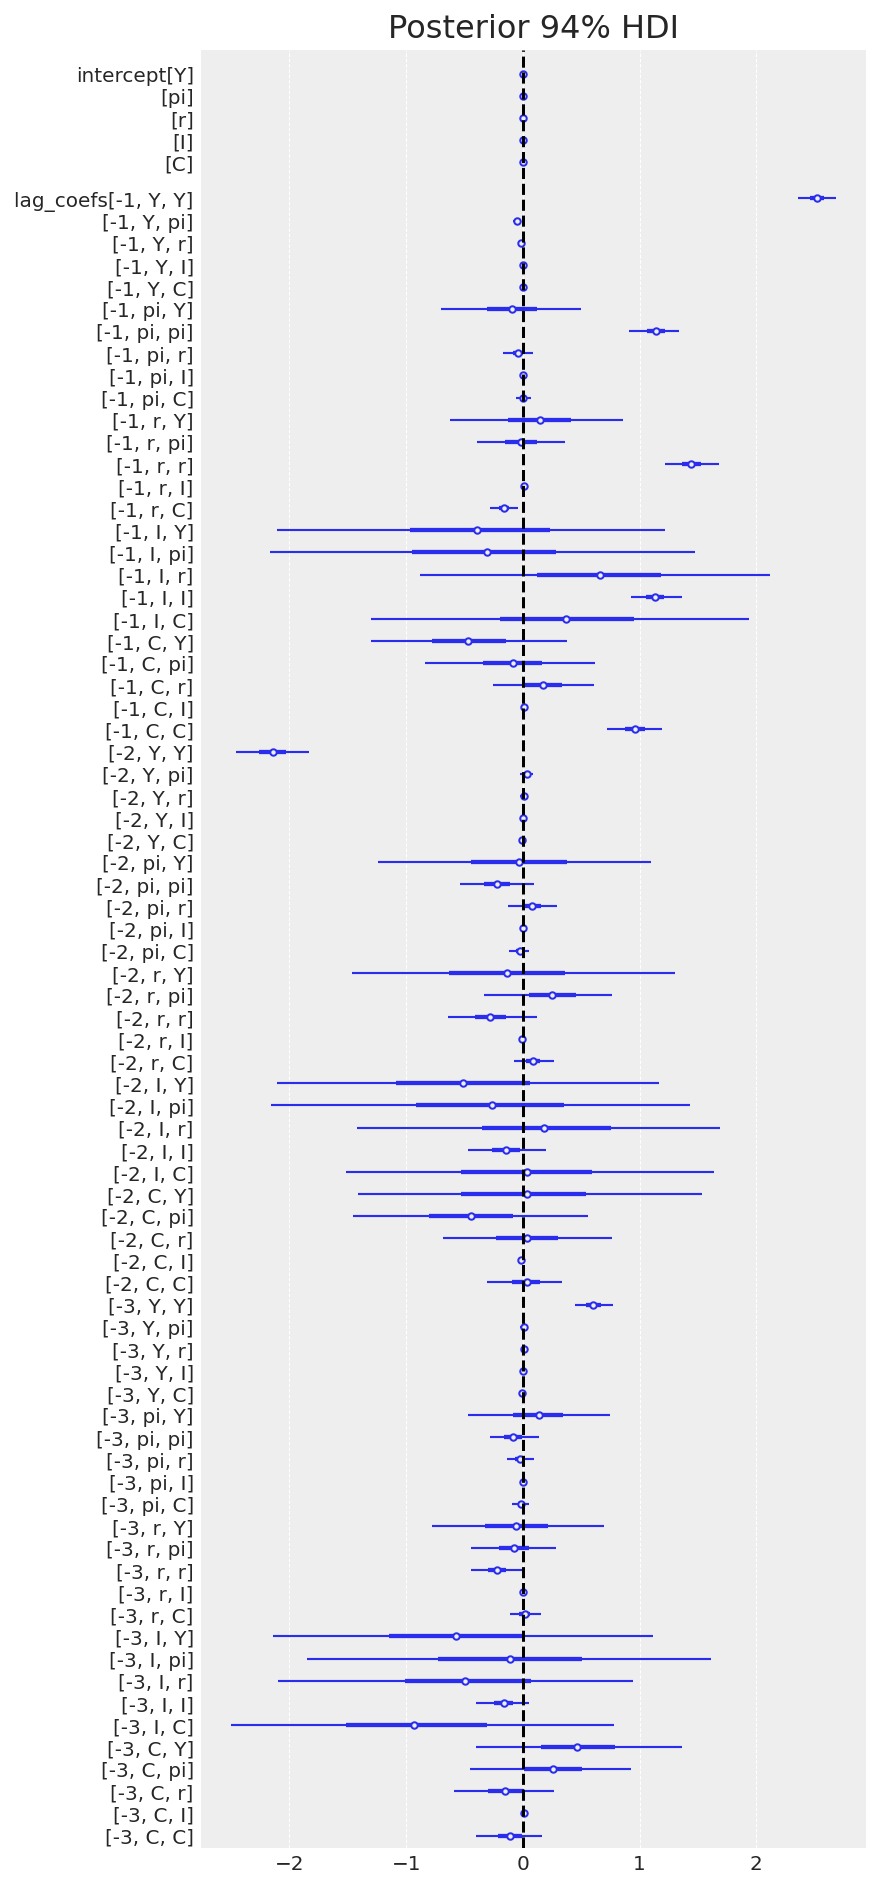

In [13]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [14]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=10):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_list = []
        for ind in range(0, len(coords['cross_vars'])):
            ar = np.sum(lag_coefs[:, ind] * new_draws[len_data+i-lags: len_data+i])
            ar_list.append(ar)
        mean = intercept + np.stack(ar_list)
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

from src.bayesian import bvar_forecast

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    # bvar_forecast(data, coords, lags, intercept, lag_coefs, noise, forecast=10),
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [15]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(3000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((100, 5), (100, 3, 5, 5), (100, 5))

In [16]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=forecast_len)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

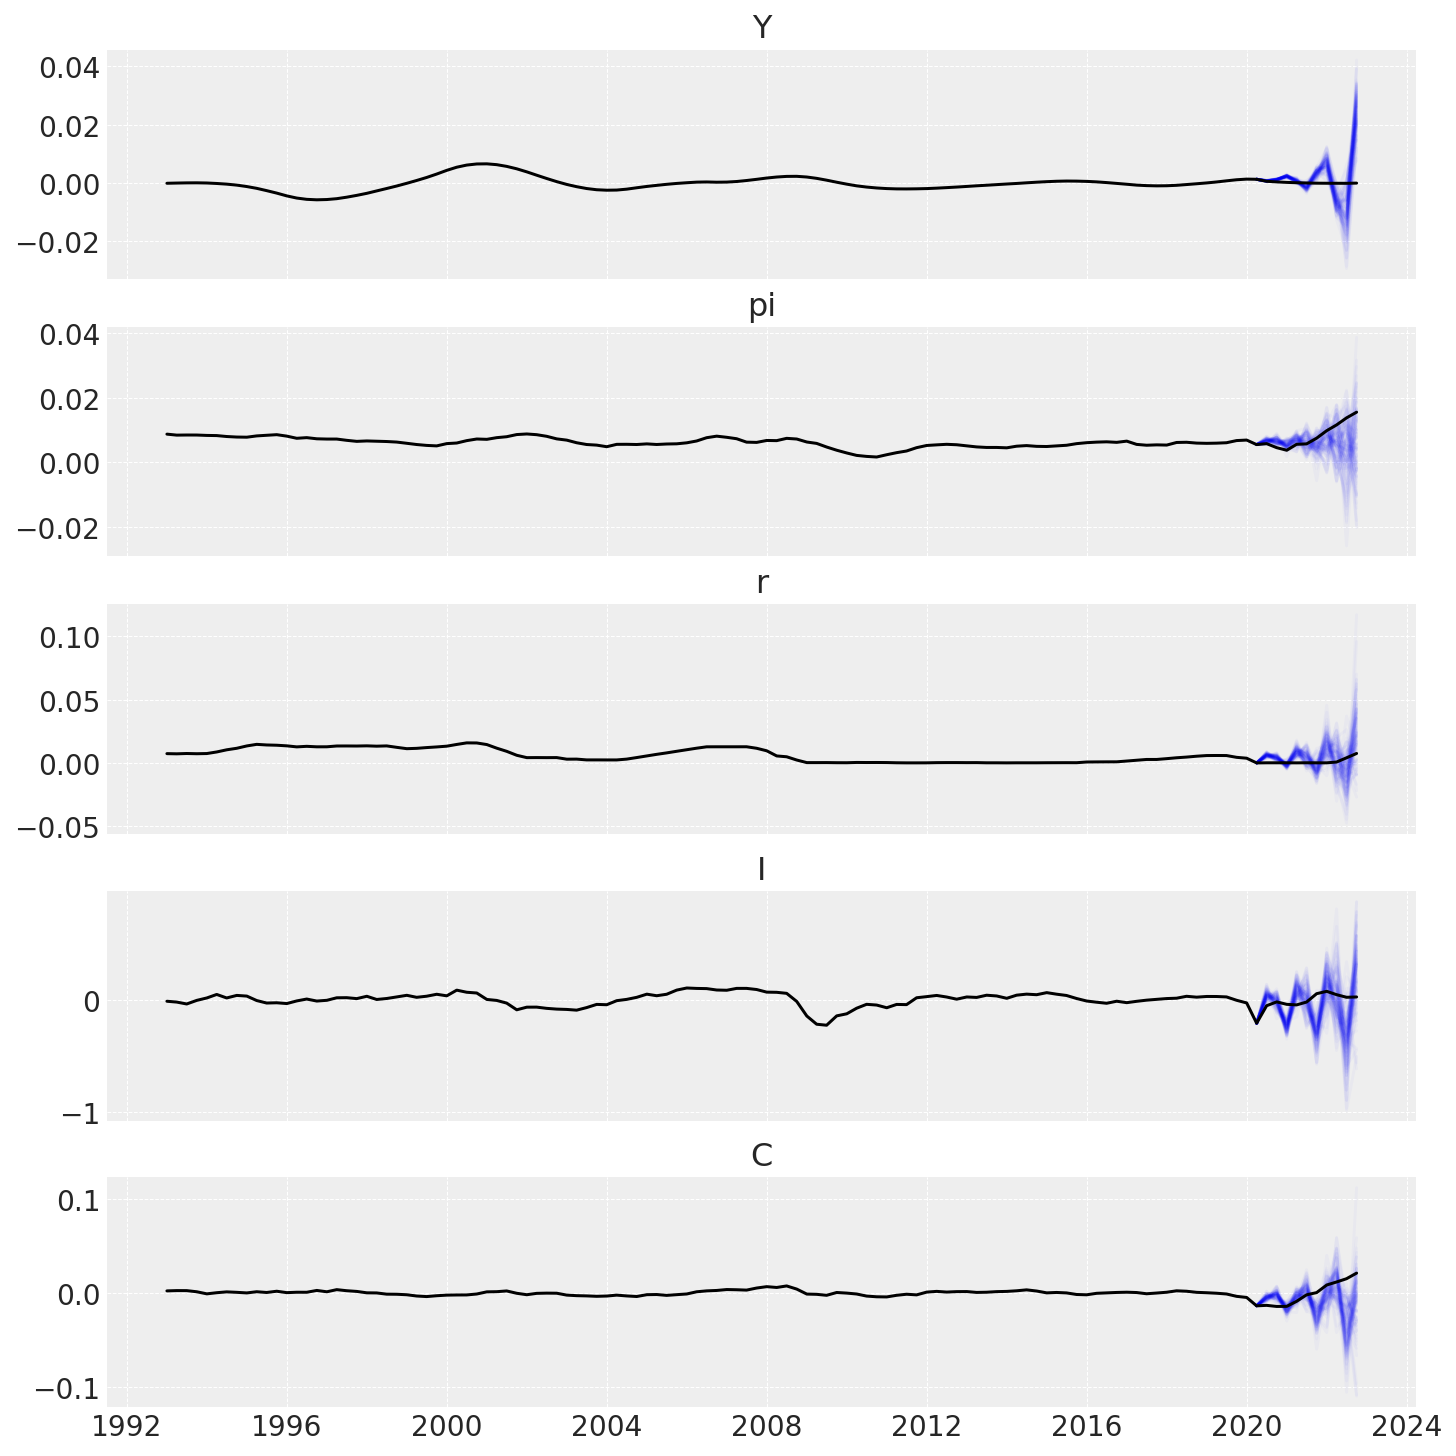

In [17]:
_, ax = plt.subplots(data.shape[1], 1, figsize=(10, 2 * df.shape[1]), sharex=True)

for i in range(0, data.shape[1]):
    ax[i].plot(df.index, ppc_draws[..., i], color="blue", alpha=.025)
    ax[i].plot(df.iloc[:, i], color="k", label="observed")
    ax[i].set_title(df.columns[i])
    ax[0].plot([], color="C0", label="forecast")

In [19]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
from settings import POST_EST_DIR

from datetime import datetime

a = ''.join(str(datetime.now().date()).split('-'))
b = ''.join((str(datetime.now().time()).split(':'))[:-1])
timestamp = '_'.join([a, b])
file_path_acc = os.path.join(POST_EST_DIR, f'bvar_accepted_{timestamp}.nc')
# tracto_netcdfne

'C:\\Users\\LukasGrahl\\Documents\\GIT\\memoire1\\data\\posterior_est_out\\bvar_accepted_20230427_0932.nc'